##**Advanced DL and RL: Домашнее задание 2**

In [179]:
import gym

import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from IPython.display import display, clear_output

SyntaxError: ignored

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком
большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно
интересной для любого слушателя. Как обычно, ​ в качестве решения ожидается ссылка
на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko);
ссылку обязательно нужно прислать в виде сданного домашнего задания на
портале Академии​ . Любые комментарии, новые идеи и рассуждения на тему, как всегда,
категорически приветствуются.

##Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован
Environment для крестиков-ноликов, в котором можно при инициализации указывать
разные размеры доски и условия победы, а также функции для рисования, в том числе с
указанием оценки различных действий. С этим окружением все задания и связаны.

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и
ноликов для доски 3х3.

1.1. Копирование класса среды "Крестиков-Ноликов" из 6 лекции с небольшими изменениями.

In [158]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [159]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [160]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [161]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    x_actions = []
    o_actions = []
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
            x_actions.append((actions[a][0], actions[a][1]))
            print("X:", x_actions)
            print("O:", o_actions)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
            o_actions.append((actions[a][0], actions[a][1]))
            print("X:", x_actions)
            print("O:", o_actions)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
            print("X:", x_actions)
            print("O:", o_actions)
            print("Крестики выиграли!")
        if reward == -1:
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
            print("X:", x_actions)
            print("O:", o_actions)
            print("Нолики выиграли!")

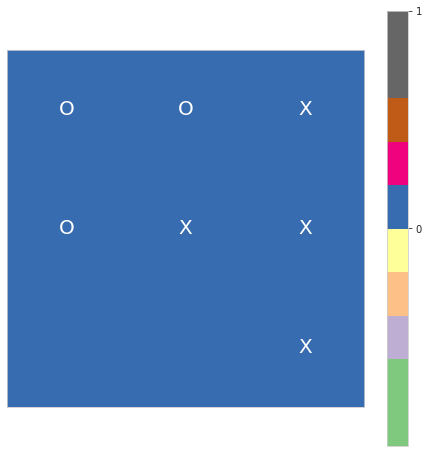

X: [(1, 1), (0, 2), (2, 2), (1, 2)]
O: [(1, 0), (0, 0), (0, 1)]
Крестики выиграли!


In [162]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

1.2. Agent и QAgent - классы агентов для обучения. Agent играет случайную стратегию, QAgent - обучается с помощью Q-обучения.

In [ ]:
class Agent():
    def __init__(self, env, player):
      self.n_cols = env.n_cols
      self.n_rows = env.n_rows
      self.player = player
      self.action_size = self.n_cols * self.n_rows
      self.state_size = np.power(3, self.action_size)
  
    def get_state_idx(self, state_hash):
        #индекс состояния = сумма троек в соответствующих степенях:
        #0 = "о", 1 = "не занято", 2 = "х"
        powers_of_3 = np.array([3 ** n for n in range(self.action_size)])
        mask = np.array(list(state_hash)).astype(int)
        return (powers_of_3 * mask).sum()

    def get_action(self, state_hash):
        mask = np.array(list(state_hash))
        #выбираем только из тех позиций, которые не заняты
        action_idx = random.choice(np.argwhere(mask == '1').flatten())
        row_idx = action_idx // self.n_rows
        col_idx = action_idx - row_idx * self.n_rows
        return row_idx, col_idx

In [ ]:
class QAgent(Agent):
    def __init__(self, env, player, eps=0.2, discount_rate=0.95, learning_rate=0.2):
        super().__init__(env, player)
        self.eps = eps
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()
        
    def build_model(self):
        self.q_table = np.zeros((self.state_size, self.action_size))
        self.q_tabele_first_use = np.ones(self.state_size)
        
    def get_action(self, state_hash):
        state = self.get_state_idx(state_hash)
        q_state = self.q_table[state]

        #заминусуем вознаграждение в тех позициях, которые
        #соответствуют занятым клеткам поля, чтобы их никогда не выбрал
        #q-алгоритм обучения
        if self.q_tabele_first_use[state]:
            mask = np.array(list(state_hash))
            zero_proba_idx = np.argwhere(mask != '1').flatten()
            q_state[zero_proba_idx] = -np.inf
            self.q_tabele_first_use[state] = 0

        action_greedy_idx = np.argmax(q_state)

        action_greedy_row_idx = action_greedy_idx // self.n_rows
        action_greedy_col_idx = action_greedy_idx - action_greedy_row_idx * self.n_rows
        action_greedy = action_greedy_row_idx, action_greedy_col_idx

        action_random = super().get_action(state_hash)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience):
        state_hash, action_idx, next_state_hash, reward, done = experience
        #учитываем, что награда ноликов = -1, а крестиков = +1
        reward = reward * self.player
        
        state = self.get_state_idx(state_hash)
        next_state = self.get_state_idx(next_state_hash)
        
        q_next = self.q_table[next_state]
        q_next = np.zeros([self.action_size]) if done else q_next

        q_target = reward + self.discount_rate * np.max(q_next)
        q_update = q_target - self.q_table[state, action_idx]
        
        self.q_table[state, action_idx] += self.learning_rate * q_update        
        if done:
            self.eps = self.eps * 0.99

1.3. Обучение стратегии крестиков на поле 3х3

In [ ]:
agent1 = QAgent(env=env, player= 1, eps=0.2)
agent2 = QAgent(env=env, player=-1, eps=1.0)

rewards1 = []
rewards2 = []

N_episodes = 100
N_epochs = 200

for epoch in range(N_epochs):
  rewards1_epoch = []
  rewards2_epoch = []  
  for ep in range(N_episodes):  
      total_reward1 = 0
      total_reward2 = 0  
      env.reset()
      state_hash = env.getHash()
      done = False
      turn = 1
      x_actions = []
      o_actions = []
      while not done:
          if turn == 1:
              action = agent1.get_action(state_hash)
              next_state, reward, done, info = env.step(action)
              next_state_hash = next_state[0]
              action_idx = action[0] * agent1.n_rows + action[1]
              agent1.train((state_hash, action_idx, next_state_hash, reward, done))
              total_reward1 += reward
              state_hash = next_state_hash
              #print("X at", turn, "a:", action)
              x_actions.append((action[0], action[1]))
              turn = -1
          else:
              action = agent2.get_action(state_hash)
              next_state, reward, done, info = env.step(action)
              next_state_hash = next_state[0]
              action_idx = action[0] * agent2.n_rows + action[1]
              #agent2.train((state_hash, action_idx, next_state_hash, reward, done))
              total_reward2 += reward
              state_hash = next_state_hash
              #print("O at", turn, "a:", action)
              o_actions.append((action[0], action[1]))
              turn = 1
          
          if epoch:
              print("Epoch: {}, episode: {}, total reward \'x\': {}, total reward \'o\': {}".format(epoch, ep, rewards1[-1], rewards2[-1]))
          else:
              print("Epoch: {}, episode: {}, total reward \'x\': {}, total reward \'o\': {}".format(epoch, ep, "--", "--"))
          print("X:", x_actions)
          print("O:", o_actions)
          env.printBoard()
          time.sleep(0.01)
          clear_output(wait=True)
      rewards1_epoch.append(total_reward1)
      rewards2_epoch.append(total_reward2)

  #считаем среднее по батчу из 10 эпизодов
  rewards1.append(np.array(rewards1_epoch).mean())
  rewards2.append(np.array(rewards2_epoch).mean()) 

Epoch: 199, episode: 99, total reward 'x': 0.75, total reward 'o': -0.24
X: [(0, 0), (0, 2), (1, 0), (1, 2), (2, 1)]
O: [(0, 1), (1, 1), (2, 0), (2, 2)]
-------------
| x | o | x | 
-------------
| x | o | x | 
-------------
| o | x | o | 
-------------


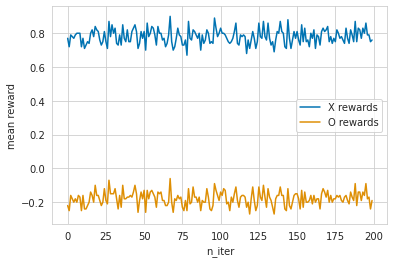

In [ ]:
plt.plot(range(N_epochs), rewards1, label = "X rewards")
plt.plot(range(N_epochs), rewards2, label = "O rewards")
plt.xlabel("n_iter")
plt.ylabel("mean reward")
plt.legend()
plt.show()

Поскольку eps = 0.2, то разумно, что в среднем агент прогрывает в 2 из 10 случаев. 

1.4. Обучение стратегии ноликов на поле 3х3

In [ ]:
agent1_new = QAgent(env=env, player=1, eps=1.0)
agent2_new = QAgent(env=env, player=-1, eps=0.2)

rewards1 = []
rewards2 = []

N_episodes = 100
N_epochs = 150

for epoch in range(N_epochs):
  rewards1_epoch = []
  rewards2_epoch = []  
  for ep in range(N_episodes):  
      total_reward1 = 0
      total_reward2 = 0  
      env.reset()
      state_hash = env.getHash()
      done = False
      turn = 1
      x_actions = []
      o_actions = []
      while not done:
          if turn == 1:
              action = agent1_new.get_action(state_hash)
              next_state, reward, done, info = env.step(action)
              next_state_hash = next_state[0]
              action_idx = action[0] * agent1_new.n_rows + action[1]
              #agent1_new.train((state_hash, action_idx, next_state_hash, reward, done))
              total_reward1 += reward
              state_hash = next_state_hash
              #print("X at", turn, "a:", action)
              x_actions.append((action[0], action[1]))
              turn = -1
          else:
              action = agent2_new.get_action(state_hash)
              next_state, reward, done, info = env.step(action)
              next_state_hash = next_state[0]
              action_idx = action[0] * agent2_new.n_rows + action[1]
              agent2_new.train((state_hash, action_idx, next_state_hash, reward, done))
              total_reward2 += reward
              state_hash = next_state_hash
              #print("O at", turn, "a:", action)
              o_actions.append((action[0], action[1]))
              turn = 1
          
          if epoch:
              print("Epoch: {}, episode: {}, total reward \'x\': {}, total reward \'o\': {}".format(epoch, ep, rewards1[-1], rewards2[-1]))
          else:
              print("Epoch: {}, episode: {}, total reward \'x\': {}, total reward \'o\': {}".format(epoch, ep, "--", "--"))
          print("X:", x_actions)
          print("O:", o_actions)
          env.printBoard()
          time.sleep(0.01)
          clear_output(wait=True)
      rewards1_epoch.append(total_reward1)
      rewards2_epoch.append(total_reward2)

  rewards1.append(np.array(rewards1_epoch).mean())
  rewards2.append(np.array(rewards2_epoch).mean()) 

Epoch: 149, episode: 99, total reward 'x': 0.51, total reward 'o': -0.46
X: [(1, 1), (1, 0), (1, 2)]
O: [(0, 0), (0, 1)]
-------------
| o | o |   | 
-------------
| x | x | x | 
-------------
|   |   |   | 
-------------


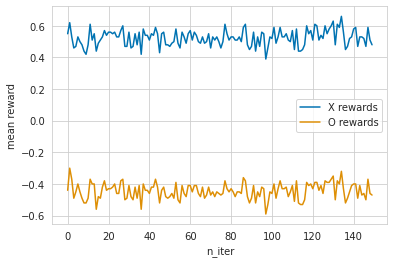

In [ ]:
plt.plot(range(N_epochs), rewards1, label = "X rewards")
plt.plot(range(N_epochs), rewards2, label = "O rewards")
plt.xlabel("n_iter")
plt.ylabel("mean reward")
plt.legend()
plt.show()

Стратегия для ноликов так плохо обучается, вероятно, потому, что в отличие от крестиков, нолики всегда идут после крестиков. Вероятно, требуется лучше подбирать значения eps и lr.

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5

In [ ]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)

2.1 Крестики

In [ ]:
agent1 = QAgent(env=env, player= 1, eps=0.2)
agent2 = QAgent(env=env, player=-1, eps=1.0)

rewards1 = []
rewards2 = []

N_episodes = 100
N_epochs = 100

for epoch in range(N_epochs):
  rewards1_epoch = []
  rewards2_epoch = []  
  for ep in range(N_episodes):  
      total_reward1 = 0
      total_reward2 = 0  
      env.reset()
      state_hash = env.getHash()
      done = False
      turn = 1
      x_actions = []
      o_actions = []
      while not done:
          if turn == 1:
              action = agent1.get_action(state_hash)
              next_state, reward, done, info = env.step(action)
              next_state_hash = next_state[0]
              action_idx = action[0] * agent1.n_rows + action[1]
              agent1.train((state_hash, action_idx, next_state_hash, reward, done))
              total_reward1 += reward
              state_hash = next_state_hash
              #print("X at", turn, "a:", action)
              x_actions.append((action[0], action[1]))
              turn = -1
          else:
              action = agent2.get_action(state_hash)
              next_state, reward, done, info = env.step(action)
              next_state_hash = next_state[0]
              action_idx = action[0] * agent2.n_rows + action[1]
              #agent2.train((state_hash, action_idx, next_state_hash, reward, done))
              total_reward2 += reward
              state_hash = next_state_hash
              #print("O at", turn, "a:", action)
              o_actions.append((action[0], action[1]))
              turn = 1
          
          if epoch:
              print("Epoch: {}, episode: {}, total reward \'x\': {}, total reward \'o\': {}".format(epoch, ep, rewards1[-1], rewards2[-1]))
          else:
              print("Epoch: {}, episode: {}, total reward \'x\': {}, total reward \'o\': {}".format(epoch, ep, "--", "--"))
          print("X:", x_actions)
          print("O:", o_actions)
          env.printBoard()
          time.sleep(0.01)
          clear_output(wait=True)
      rewards1_epoch.append(total_reward1)
      rewards2_epoch.append(total_reward2)

  rewards1.append(np.array(rewards1_epoch).mean())
  rewards2.append(np.array(rewards2_epoch).mean()) 

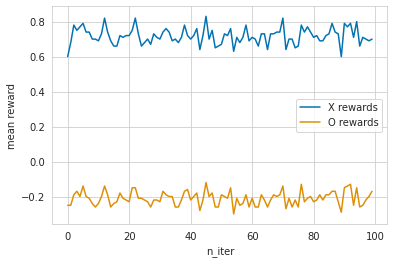

In [ ]:
plt.plot(range(N_epochs), rewards1, label = "X rewards")
plt.plot(range(N_epochs), rewards2, label = "O rewards")
plt.xlabel("n_iter")
plt.ylabel("mean reward")
plt.legend()
plt.show()

Результат аналогичен случаю с полем 3х3.

2.2 Нолики

In [ ]:
agent1 = QAgent(env=env, player=1, eps=1.0)
agent2 = QAgent(env=env, player=-1, eps=0.2)

rewards1 = []
rewards2 = []

N_episodes = 100
N_epochs = 100

for epoch in range(N_epochs):
  rewards1_epoch = []
  rewards2_epoch = []  
  for ep in range(N_episodes):  
      total_reward1 = 0
      total_reward2 = 0  
      env.reset()
      state_hash = env.getHash()
      done = False
      turn = 1
      x_actions = []
      o_actions = []
      while not done:
          if turn == 1:
              action = agent1.get_action(state_hash)
              next_state, reward, done, info = env.step(action)
              next_state_hash = next_state[0]
              action_idx = action[0] * agent1.n_rows + action[1]
              #agent1.train((state_hash, action_idx, next_state_hash, reward, done))
              total_reward1 += reward
              state_hash = next_state_hash
              #print("X at", turn, "a:", action)
              x_actions.append((action[0], action[1]))
              turn = -1
          else:
              action = agent2.get_action(state_hash)
              next_state, reward, done, info = env.step(action)
              next_state_hash = next_state[0]
              action_idx = action[0] * agent2.n_rows + action[1]
              agent2.train((state_hash, action_idx, next_state_hash, reward, done))
              total_reward2 += reward
              state_hash = next_state_hash
              #print("O at", turn, "a:", action)
              o_actions.append((action[0], action[1]))
              turn = 1
          
          if epoch:
              print("Epoch: {}, episode: {}, total reward \'x\': {}, total reward \'o\': {}".format(epoch, ep, rewards1[-1], rewards2[-1]))
          else:
              print("Epoch: {}, episode: {}, total reward \'x\': {}, total reward \'o\': {}".format(epoch, ep, "--", "--"))
          print("X:", x_actions)
          print("O:", o_actions)
          env.printBoard()
          time.sleep(0.01)
          clear_output(wait=True)
      rewards1_epoch.append(total_reward1)
      rewards2_epoch.append(total_reward2)

  rewards1.append(np.array(rewards1_epoch).mean())
  rewards2.append(np.array(rewards2_epoch).mean()) 

Epoch: 99, episode: 99, total reward 'x': 0.3, total reward 'o': -0.54
X: [(3, 2), (1, 2), (1, 0), (1, 3)]
O: [(0, 0), (0, 1), (0, 2), (0, 3)]
-----------------
| o | o | o | o | 
-----------------
| x |   | x | x | 
-----------------
|   |   |   |   | 
-----------------
|   |   | x |   | 
-----------------


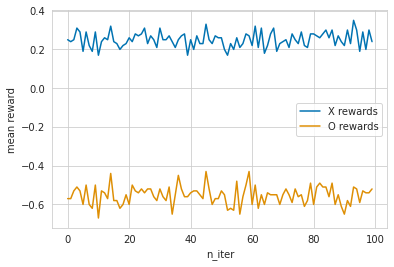

In [ ]:
plt.plot(range(N_epochs), rewards1, label = "X rewards")
plt.plot(range(N_epochs), rewards2, label = "O rewards")
plt.xlabel("n_iter")
plt.ylabel("mean reward")
plt.legend()
plt.show()

Результат лучше, чем в случае поля 3х3. Вероятно, так происходит потому, что в случае бОльшего поля вероятность случайно выбрать правильную ячейку ниже, т.е. случайная стратегия играет хуже, но, тем не менее, требуется специальный подбор eps и lr, чтобы лучше обучить. Заметим, что выигрывают крестики приблизительно в 2-3 из 10 случаев при eps=0.2, что логично. В 2-3 случаях из 10 - ничья.

In [ ]:
del agent1, agent2

##Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду
ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов.
Замечание: скорее всего, experience replay потребуется сразу же.

3.1 Реализация DQN с нейронной сетью

In [167]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [168]:
env = TicTacToe(3, 3, 3) 

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [164]:
class Policy(nn.Module):
    def __init__(self, n_positions, n_nodes=128):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(n_positions, n_nodes)
        self.fc2 = nn.Linear(n_nodes, n_nodes)
        self.fc3 = nn.Linear(n_nodes, n_positions)
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)
        torch.nn.init.xavier_uniform(self.fc3.weight)
        self.fc1.bias.data.fill_(0.01)
        self.fc2.bias.data.fill_(0.01)
        self.fc3.bias.data.fill_(0.01)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [193]:
class TicTacToeDQN():
    def __init__(self, player, n_nodes, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
        self.model = Policy(n_rows * n_cols, n_nodes)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        self.player = player

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)

    def select_random_action(self):
        indices = np.argwhere(self.env.board.flatten() == 0).flatten()
        #print(indices)
        #self.env.printBoard()
        return torch.tensor([[random.choice(indices)]], dtype=torch.int64)        

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return self.select_random_action()
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        self.env.reset()
        state = None
        action_idx = None
        num_step = 0
        x_actions = []
        o_actions = []
        loss_hist = []
        
        if self.player == -1:
            action_idx = self.select_random_action()
            action = self.env.action_from_int(action_idx.cpu().numpy()[0][0])
            _ = self.env.step(action)
            state = np.array(list(self.env.getHash())).astype(int)
            x_actions.append(action)
        else:
            state = np.array(list(self.env.getHash())).astype(int)
        

        while True:
            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action_idx = self.select_greedy_action(state_tensor)
                else:
                    action_idx = self.select_action(state_tensor)
            action = self.env.action_from_int(action_idx.cpu().numpy()[0][0])
            
            if self.player == 1:
                x_actions.append(action)
            else:
                o_actions.append(action)
            
            next_state, reward, done, _ = self.env.step(action)
            next_state_board = np.array(list(next_state[0])).astype(int)
            next_state_tensor = torch.tensor([next_state_board], dtype=torch.float32)

            true_reward = reward
            reward = (abs(reward) == 1) * self.player * reward + (abs(reward) != 1) * reward

            transition = (state_tensor, action_idx, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                loss = self.learn()
                if loss is not None:
                    loss_hist.append(loss)

            state = next_state_board
            num_step += 1

            if done:
                self.episode_durations.append(num_step)
                break


            action_idx = self.select_random_action()
            action = self.env.action_from_int(action_idx.cpu().numpy()[0][0])
            next_state, true_reward, done, _ = self.env.step(action)
            state = np.array(list(next_state[0])).astype(int)

            assert(true_reward != -10)
            
            if self.player == -1:
                x_actions.append(action)
            else:
                o_actions.append(action)
            
            if done:
                self.episode_durations.append(num_step)
                break

        return true_reward, loss_hist, x_actions, o_actions

    def learn(self):
        if len(self.memory) < self.batch_size:
            return None

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        #print(batch_action)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q

        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.cpu().detach().numpy()

3.2 Обучение стратегии крестиков.

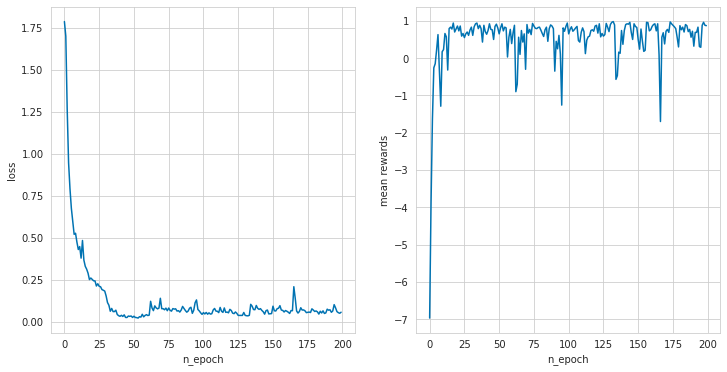

Epoch: 199, loss: 0.05770000070333481, mean reward = 0.87


In [198]:
N_epochs = 200
N_episodes = 100

TicTacToe3x3 = TicTacToeDQN(1, 128, 3, 3, 3)

loss_hist = []
rewards_hist = []

for epoch in range(N_epochs):
    loss_epoch = []
    rewards_epoch = []
    for episode in range(N_episodes):
        true_reward, loss, _, _ = TicTacToe3x3.run_episode(e=episode)
        if len(loss):
            loss_epoch.append(loss[-1])
        rewards_epoch.append(true_reward)

    loss_hist.append(np.mean(loss_epoch))
    rewards_hist.append(np.mean(rewards_epoch))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(range(epoch + 1), loss_hist)
    ax2.plot(range(epoch + 1), rewards_hist)
    ax1.set_xlabel("n_epoch")
    ax2.set_xlabel("n_epoch")
    ax1.set_ylabel("loss")
    ax2.set_ylabel("mean rewards")
    plt.show()
    print(f"Epoch: {epoch}, loss: {round(loss_hist[-1], 4)}, mean reward = {round(rewards_hist[-1], 4)}")
    time.sleep(0.01)
    clear_output(wait=True)

Как и ожидалось, обучение происходит быстрее и с меньшей дисперсией по сравнению с обычным табличным обучением.

3.3 Обучение стратегии ноликов.

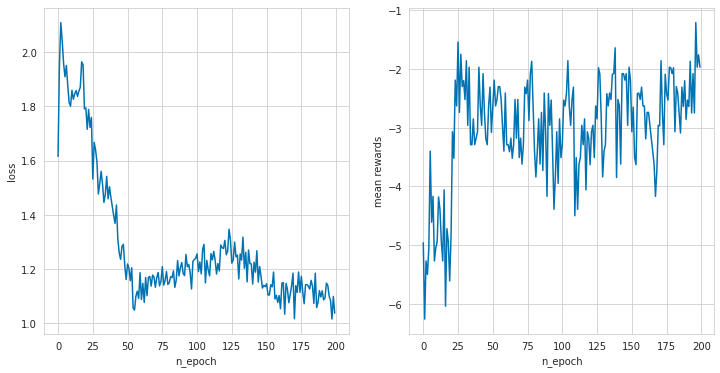

Epoch: 199, loss: 1.0358999967575073, mean reward = -1.97


In [199]:
N_epochs = 200
N_episodes = 100

TicTacToe3x3 = TicTacToeDQN(-1, 128, 3, 3, 3)

loss_hist = []
rewards_hist = []

for epoch in range(N_epochs):
    loss_epoch = []
    rewards_epoch = []
    for episode in range(N_episodes):
        true_reward, loss, _, _ = TicTacToe3x3.run_episode(e=episode)
        if true_reward == -1:
            true_reward = -true_reward
        if len(loss):
            loss_epoch.append(loss[-1])
        rewards_epoch.append(true_reward)

    loss_hist.append(np.mean(loss_epoch))
    rewards_hist.append(np.mean(rewards_epoch))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(range(epoch + 1), loss_hist)
    ax2.plot(range(epoch + 1), rewards_hist)
    ax1.set_xlabel("n_epoch")
    ax2.set_xlabel("n_epoch")
    ax1.set_ylabel("loss")
    ax2.set_ylabel("mean rewards")
    plt.show()
    print(f"Epoch: {epoch}, loss: {round(loss_hist[-1], 4)}, mean reward = {round(rewards_hist[-1], 4)}")
    time.sleep(0.01)
    clear_output(wait=True)

Как и в случае с табличным обучением, требуется более длительное обучение и более тонкий подбор параметров обучения для ноликов, которые ходят вторыми. Кроме того, в отличие от табличного обучения, жадная стратегия может выбрать занятую клетку, т.е. дополнительно требуется выучить правила.

##Часть третья: расширим и углубим поиск

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с
неслучайной, но простой стратегией (например, основанной на дополнениинескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями,
обученными в первых двух частях.